In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

import statsmodels.api as sm

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

# 1 
Load the houseprices data from Thinkful's database.

In [4]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"
table_name = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from {}".format(table_name), con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

# 2
Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [5]:
house_prices_df = df.copy()

<IPython.core.display.Javascript object>

In [6]:
df = df.drop(columns=["poolqc", "miscfeature", "alley", "fence"])
# There doesn't seem to be any way to really interpolate or otherwise substitute these values.
# Doing so would create unreliable data. I have no problem dropping them.

<IPython.core.display.Javascript object>

In [7]:
df[df["fireplacequ"].isna()]["fireplaces"].value_counts()

0    690
Name: fireplaces, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df["fireplaces"].value_counts()

0    690
1    650
2    115
3      5
Name: fireplaces, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# Seems like all instances where there are 0 fireplaces,
# there is a NaN stored for the fireplace quality.
# Could be considered redundant information.
df["fireplacequ"] = df["fireplacequ"].fillna("None")

<IPython.core.display.Javascript object>

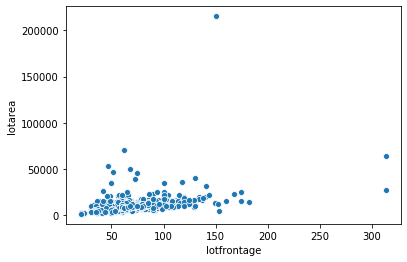

<IPython.core.display.Javascript object>

In [10]:
sns.scatterplot(
    "lotfrontage", "lotarea", data=df
)  # probably not the best to interpolate off of

In [11]:
# Can't seem to find any rhyme or reason to the missing values.
# I think median imputation is probably an ok fix here.
df["lotfrontage"] = df["lotfrontage"].fillna(df["lotfrontage"].median())

<IPython.core.display.Javascript object>

In [12]:
df.isna().mean().sort_values(ascending=False).head(20)

garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagecond      0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrtype      0.005479
masvnrarea      0.005479
electrical      0.000685
roofmatl        0.000000
roofstyle       0.000000
saleprice       0.000000
exterior1st     0.000000
exterior2nd     0.000000
yearbuilt       0.000000
exterqual       0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [13]:
df["garagecars"].value_counts() / df.shape[0]
# looks like all the nas are encapsulated in the entries where garagecars == 0
# putting in a 'none' class seems like adding redundant information.
# there seems to be a lot of overlap in general for information contained in the garage columns

2    0.564384
1    0.252740
3    0.123973
0    0.055479
4    0.003425
Name: garagecars, dtype: float64

<IPython.core.display.Javascript object>

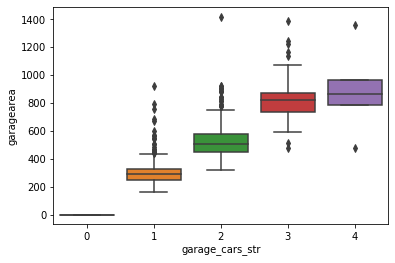

<IPython.core.display.Javascript object>

In [14]:
df["garage_cars_str"] = df["garagecars"].astype(str)
sns.boxplot(x="garage_cars_str", y="garagearea", data=df)

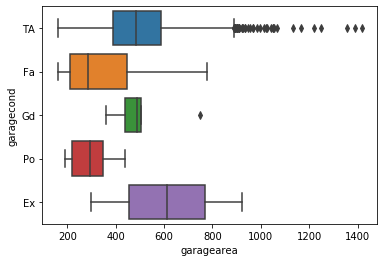

<IPython.core.display.Javascript object>

In [15]:
sns.boxplot(x="garagearea", y="garagecond", data=df)

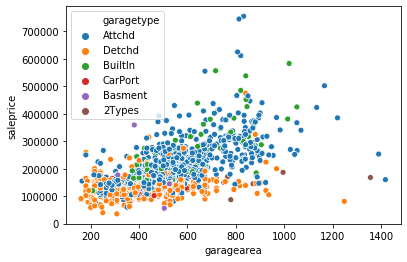

<IPython.core.display.Javascript object>

In [16]:
sns.scatterplot(x="garagearea", y="saleprice", hue="garagetype", data=df)

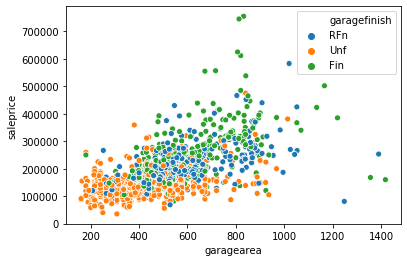

<IPython.core.display.Javascript object>

In [17]:
sns.scatterplot(x="garagearea", y="saleprice", hue="garagefinish", data=df)

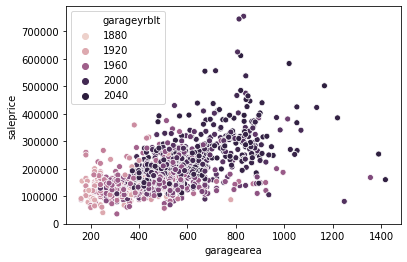

<IPython.core.display.Javascript object>

In [18]:
sns.scatterplot(x="garagearea", y="saleprice", hue="garageyrblt", data=df)

The only factors that seem to have any relevancy to saleprice is area, type, finish, and yearbuilt. Yearbuilt I think should be handled with a low impact central tendency imputation. Area could be set to 0. And for categoricals, just set them to 'none'. Every other feature can either be explained from either or has low impact on saleprice

In [19]:
df = df.drop(columns=["garagequal", "garagecond"])

<IPython.core.display.Javascript object>

In [20]:
df["garageyrblt"] = df["garageyrblt"].fillna(df["garageyrblt"].median())
df["garagefinish"] = df["garagefinish"].fillna("None")
df["garagetype"] = df["garagetype"].fillna("None")

<IPython.core.display.Javascript object>

In [21]:
bsmt_cols = ["bsmtfintype2", "bsmtexposure", "bsmtfintype1", "bsmtcond", "bsmtqual"]
for col in bsmt_cols:
    df[col] = df[col].fillna("None")

<IPython.core.display.Javascript object>

In [22]:
df["masvnrarea"] = df["masvnrarea"].fillna(0.0)

<IPython.core.display.Javascript object>

In [23]:
df["masvnrtype"] = df["masvnrtype"].fillna("None")

<IPython.core.display.Javascript object>

In [24]:
df.isna().mean().sort_values(ascending=False).head(10)

electrical         0.000685
garage_cars_str    0.000000
extercond          0.000000
roofstyle          0.000000
roofmatl           0.000000
exterior1st        0.000000
exterior2nd        0.000000
masvnrtype         0.000000
masvnrarea         0.000000
exterqual          0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [25]:
df = df.dropna()

<IPython.core.display.Javascript object>

In [26]:
#house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat(
    [
        house_prices_df,
        pd.get_dummies(house_prices_df.centralair, prefix="centralair", drop_first=True),
    ],
    axis=1,
)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.exterqual, prefix="exterqual", drop_first=True)], axis=1)


#dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = list(
    pd.get_dummies(
        house_prices_df.centralair, prefix="centralair", drop_first=True
    ).columns
)

dummy_column_names = dummy_column_names + list(
    pd.get_dummies(
        house_prices_df.exterqual, prefix="exterqual", drop_first=True
    ).columns
)



<IPython.core.display.Javascript object>

In [27]:
house_prices_df["totalsf"] = (
    house_prices_df["totalbsmtsf"]
    + house_prices_df["firstflrsf"]
    + house_prices_df["secondflrsf"]
)

house_prices_df["int_over_sf"] = (
    house_prices_df["totalsf"] * house_prices_df["overallqual"]
)



<IPython.core.display.Javascript object>

In [28]:
house_prices_df.sort_values(by="totalsf", ascending=False)  # problematic outlier
house_prices_df = house_prices_df.drop(1298)

<IPython.core.display.Javascript object>

In [29]:
y = np.log(house_prices_df["saleprice"])
# X is the feature set
X = house_prices_df[
    ["lotarea", "overallqual", "garagecars", "int_over_sf", "totalsf"]
    + dummy_column_names
]
# X = X.drop(columns=["masvnrtype_None", "masvnrtype_BrkFace"])
X_const = sm.add_constant(X)

results = sm.OLS(y, X_const).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     874.8
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:53:24   Log-Likelihood:                 626.62
No. Observations:                1459   AIC:                            -1233.
Df Residuals:                    1449   BIC:                            -1180.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.5719      0.059    179.519      0.000      10.456      10.687
lotarea       3.315e-06   4.42e-07      7.497      0.000    2.45e-06    4.18e-06
overallqual      0.1154      0.009     12.231      0.000       0.097       0.134
garagecars       0.0841      0.007     11.491      0.000       0.070       0.098
int_over_sf  -7.877e-06    3.2e-06     -2.464      0.014   -1.41e-05   -1.61e-06
totalsf          0.0003   2.25e-05     11.212      0.000       0.000       0.000
centralair_Y     0.1939      0.018     10.739      0.000       0.158       0.229
exterqual_Fa    -0.2629      0.053     -4.919      0.000      -0.368      -0.158
exterqual_Gd    -0.0799      0.027     -2.989      0.003      -0.132      -0.027
exterqual_TA    -0.1676      0.030     -5.618      0.000      -0.226      -0.109
==============================================================================
Omnibus:                      542.478   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4954.078
Skew:                          -1.469   Prob(JB):                         0.00
Kurtosis:                      11.536   Cond. No.                     3.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

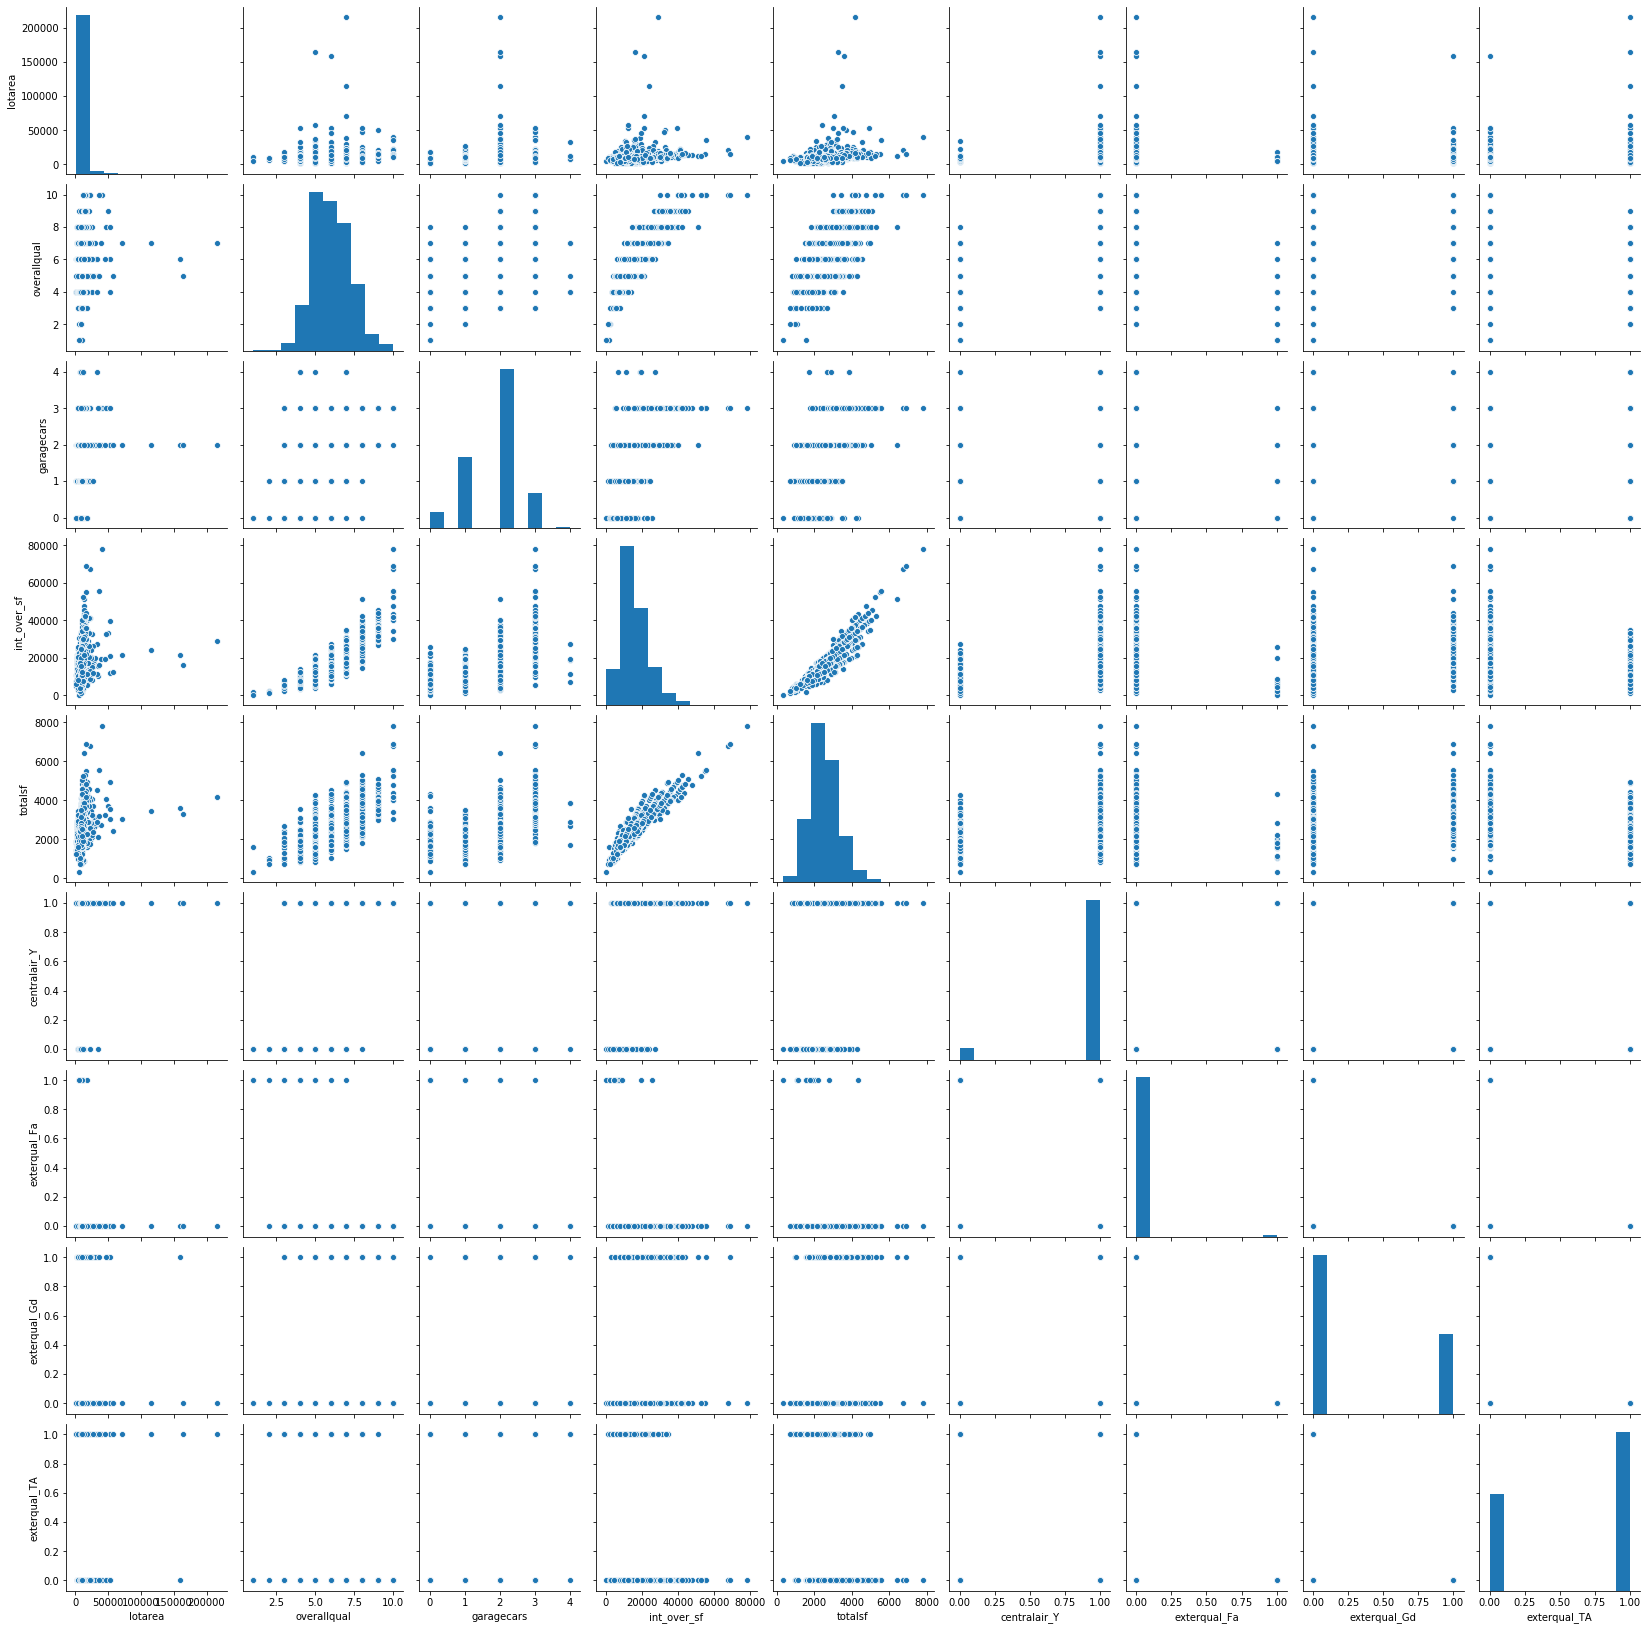

<IPython.core.display.Javascript object>

In [30]:
sns.pairplot(X)

In [31]:
print_vif(X)

VIF results
-------------------------------
const           202.612771
lotarea           1.115954
overallqual       9.890605
garagecars        1.746601
int_over_sf      40.644357
totalsf          18.276614
centralair_Y      1.159513
exterqual_Fa      1.585436
exterqual_Gd      9.296721
exterqual_TA     12.233294
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

# 3
Now, split your data into train and test sets where 20% of the data resides in the test set.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=34
)

<IPython.core.display.Javascript object>

# 4
Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [33]:
grid = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": [0, 0.25, 0.5, 0.75, 1.0]}
# by including ratios of 0 and 1, this should test if solely ridge or LASSO is better
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 0.001
selected l1_ratio: 0.25


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished


array([ 2.95539782e-06,  1.13029242e-01,  7.91100810e-02, -7.11130966e-06,
        2.49180025e-04,  1.91528462e-01, -2.15805679e-01, -4.90192035e-02,
       -1.39166940e-01])

<IPython.core.display.Javascript object>

# 5 
Evaluate your best model on the test set

In [34]:
elasticnet_cv.score(X_test, y_test)

0.8363815134117397

<IPython.core.display.Javascript object>

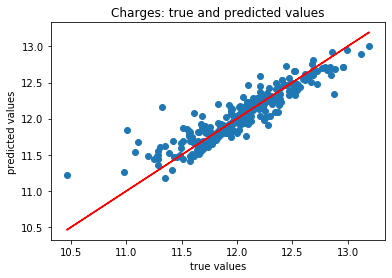

Mean absolute error of the prediction is: 0.11681831507329206
Mean squared error of the prediction is: 0.027691207505567195
Root mean squared error of the prediction is: 0.16640675318498102
Mean absolute percentage error of the prediction is: 0.9816575718096835


<IPython.core.display.Javascript object>

In [35]:
y_preds = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print(
    "Mean absolute error of the prediction is: {}".format(
        mean_absolute_error(y_test, y_preds)
    )
)
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print(
    "Mean absolute percentage error of the prediction is: {}".format(
        np.mean(np.abs((y_test - y_preds) / y_test)) * 100
    )
)

These metrics seem pretty good overall. Getting within 1% for each prediction is quite good. And 0.83 R-squared is great

In [36]:
df["yrsold"].unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

<IPython.core.display.Javascript object>

In [37]:
mortgage_rates = {2006: 6.41, 2007: 6.34, 2008: 6.03, 2009: 5.04, 2010: 4.69}
df["mortgage_rates"] = df["yrsold"]

df["mortgage_rates"] = df["mortgage_rates"].replace(to_replace=mortgage_rates)

<IPython.core.display.Javascript object>

In [38]:
house_prices_df = df.copy()
#house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat(
    [
        house_prices_df,
        pd.get_dummies(house_prices_df.centralair, prefix="centralair", drop_first=True),
    ],
    axis=1,
)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.exterqual, prefix="exterqual", drop_first=True)], axis=1)


#dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = list(
    pd.get_dummies(
        house_prices_df.centralair, prefix="centralair", drop_first=True
    ).columns
)

dummy_column_names = dummy_column_names + list(
    pd.get_dummies(
        house_prices_df.exterqual, prefix="exterqual", drop_first=True
    ).columns
)

house_prices_df["totalsf"] = (
    house_prices_df["totalbsmtsf"]
    + house_prices_df["firstflrsf"]
    + house_prices_df["secondflrsf"]
)

house_prices_df["int_over_sf"] = (
    house_prices_df["totalsf"] * house_prices_df["overallqual"]
)
house_prices_df = house_prices_df.drop(1298) #problematic outlier


<IPython.core.display.Javascript object>

In [39]:
y = np.log(house_prices_df["saleprice"])
# X is the feature set
X = house_prices_df[
    ["lotarea", "overallqual", "garagecars", "int_over_sf", "totalsf", "mortgage_rates"]
    + dummy_column_names
]
# X = X.drop(columns=["masvnrtype_None", "masvnrtype_BrkFace"])
X_const = sm.add_constant(X)

results = sm.OLS(y, X_const).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     788.7
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:53:41   Log-Likelihood:                 627.62
No. Observations:                1458   AIC:                            -1233.
Df Residuals:                    1447   BIC:                            -1175.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.5386      0.068    153.990      0.000      10.404      10.673
lotarea          3.31e-06   4.42e-07      7.489      0.000    2.44e-06    4.18e-06
overallqual        0.1157      0.009     12.275      0.000       0.097       0.134
garagecars         0.0836      0.007     11.430      0.000       0.069       0.098
int_over_sf    -8.028e-06    3.2e-06     -2.512      0.012   -1.43e-05   -1.76e-06
totalsf            0.0003   2.25e-05     11.268      0.000       0.000       0.000
mortgage_rates     0.0057      0.006      0.907      0.364      -0.007       0.018
centralair_Y       0.1937      0.018     10.734      0.000       0.158       0.229
exterqual_Fa      -0.2618      0.053     -4.901      0.000      -0.367      -0.157
exterqual_Gd      -0.0815      0.027     -3.042      0.002      -0.134      -0.029
exterqual_TA      -0.1696      0.030     -5.677      0.000      -0.228      -0.111
==============================================================================
Omnibus:                      543.895   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4996.261
Skew:                          -1.474   Prob(JB):                         0.00
Kurtosis:                      11.577   Cond. No.                     3.99e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

Adding mortgage rates by year doesn't have any impact on the model

In [41]:
unemp = pd.read_csv("data/unemp.csv", index_col=0)
# taken from https://www.iowaworkforcedevelopment.gov/local-area-unemployment-statistics
#unemployment rates by county, by month in Iowa
#processed and took relevant info to merge with df

<IPython.core.display.Javascript object>

In [42]:
unemp.head()

,MONTH,YEAR,UNEMPRATE
35554,1,2006,2.9
35555,2,2006,2.9
35556,3,2006,2.7
35557,4,2006,2.4
35558,5,2006,2.5


<IPython.core.display.Javascript object>

In [43]:
def get_unemp_rate(month, year):
    return_df = unemp[unemp["MONTH"] == month]
    return_df = return_df[return_df["YEAR"] == year]
    val = return_df["UNEMPRATE"].values
    return val[0]

<IPython.core.display.Javascript object>

In [44]:
df["unemp_rate"] = df.apply(lambda x: get_unemp_rate(x["mosold"], x["yrsold"]), axis=1)

<IPython.core.display.Javascript object>

In [45]:
house_prices_df = df.copy()
#house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat(
    [
        house_prices_df,
        pd.get_dummies(house_prices_df.centralair, prefix="centralair", drop_first=True),
    ],
    axis=1,
)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.exterqual, prefix="exterqual", drop_first=True)], axis=1)


#dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = list(
    pd.get_dummies(
        house_prices_df.centralair, prefix="centralair", drop_first=True
    ).columns
)

dummy_column_names = dummy_column_names + list(
    pd.get_dummies(
        house_prices_df.exterqual, prefix="exterqual", drop_first=True
    ).columns
)

house_prices_df["totalsf"] = (
    house_prices_df["totalbsmtsf"]
    + house_prices_df["firstflrsf"]
    + house_prices_df["secondflrsf"]
)

house_prices_df["int_over_sf"] = (
    house_prices_df["totalsf"] * house_prices_df["overallqual"]
)
house_prices_df = house_prices_df.drop(1298) #problematic outlier


<IPython.core.display.Javascript object>

In [46]:
y = np.log(house_prices_df["saleprice"])
# X is the feature set
X = house_prices_df[
    [
        "lotarea",
        "overallqual",
        "garagecars",
        "int_over_sf",
        "totalsf",
        "mortgage_rates",
        "unemp_rate",
    ]
    + dummy_column_names
]
# X = X.drop(columns=["masvnrtype_None", "masvnrtype_BrkFace"])
X_const = sm.add_constant(X)

results = sm.OLS(y, X_const).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     716.5
Date:                Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:53:45   Log-Likelihood:                 627.63
No. Observations:                1458   AIC:                            -1231.
Df Residuals:                    1446   BIC:                            -1168.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.5519      0.119     88.310      0.000      10.318      10.786
lotarea         3.313e-06   4.43e-07      7.483      0.000    2.44e-06    4.18e-06
overallqual        0.1157      0.009     12.264      0.000       0.097       0.134
garagecars         0.0837      0.007     11.424      0.000       0.069       0.098
int_over_sf    -8.022e-06    3.2e-06     -2.509      0.012   -1.43e-05   -1.75e-06
totalsf            0.0003   2.25e-05     11.259      0.000       0.000       0.000
mortgage_rates     0.0041      0.013      0.318      0.750      -0.021       0.030
unemp_rate        -0.0012      0.009     -0.136      0.892      -0.019       0.016
centralair_Y       0.1938      0.018     10.724      0.000       0.158       0.229
exterqual_Fa      -0.2619      0.053     -4.900      0.000      -0.367      -0.157
exterqual_Gd      -0.0814      0.027     -3.041      0.002      -0.134      -0.029
exterqual_TA      -0.1696      0.030     -5.675      0.000      -0.228      -0.111
==============================================================================
Omnibus:                      544.003   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4999.800
Skew:                          -1.474   Prob(JB):                         0.00
Kurtosis:                      11.580   Cond. No.                     6.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [47]:
grid = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": [0, 0.25, 0.5, 0.75, 1.0]}
# by including ratios of 0 and 1, this should test if solely ridge or LASSO is better
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 0.001
selected l1_ratio: 0.25


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished


array([ 2.95539782e-06,  1.13029242e-01,  7.91100810e-02, -7.11130966e-06,
        2.49180025e-04,  1.91528462e-01, -2.15805679e-01, -4.90192035e-02,
       -1.39166940e-01])

<IPython.core.display.Javascript object>

In [48]:
elasticnet_cv.score(X_test, y_test)

0.8363815134117397

<IPython.core.display.Javascript object>

I tried adding both mortgage rates by year and even unemployment rates down to the month. Neither of them had a significant impact on the data. It's to be expected because those rates were on a national level so it could be much different in Ames, Iowa which is where this was conducted. I tried to get unemployment data for that county in particular (Story County). It seemed to have even less of an effect on the data. It might be better to look at Iowa as a whole. I think it has a lot of potential to add bias to the system whenever choosing data to merge with an existing set, since we are cherry picking the features to bring in. I think there's potential to add a lot of information but I simply don't have the time to fully research such factors and implement them.